In [21]:
import sys
import os
import collections
from collections import defaultdict
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import re
from tabula import read_pdf
import csv

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

import requests
from bs4 import BeautifulSoup

plt.rcParams['figure.figsize'] = (15, 8)  # Width=15, Height=8


In [3]:
print("Opening BAC2019 csv...")
data_bac = pd.read_csv("./BAC CSV/bac2019.csv", skip_blank_lines=True)
data_bac.head(10)

Opening BAC2019 csv...


,Cod unic candidat,Sex,Specializare,Profil,Filiera,Forma de învățământ,Mediu candidat,Subiect ea,Subiect eb,Limba modernă,...,SCRIS_PMS,ORAL_PMO,ORAL_IO,PUNCTAJ DIGITALE,STATUS,Medie,NOTA_FINALA_EA,NOTA_FINALA_EB,NOTA_FINALA_EC,NOTA_FINALA_ED
0,10530,M,Filologie,Uman,Teoretică,Zi,URBAN,Limba română (UMAN),NaN,Limba engleză,...,A2,B2,B2,22.0,Promovat,6.01,5.00,NaN,5.25,7.80
1,11067,F,Științe Sociale,Uman,Teoretică,Frecvență redusă,URBAN,Limba română (UMAN),NaN,Limba engleză,...,B1,B2,B2,44.0,Nepromovat,5.38,5.90,NaN,5.25,5.00
2,11185,M,Științe ale Naturii,Real,Teoretică,Zi,URBAN,Limba română (REAL),NaN,Limba engleză,...,-,B1,B1,NaN,Nepromovat,NaN,3.60,NaN,7.00,5.10
3,12449,M,Matematica-Informatica,Real,Teoretică,Zi,URBAN,Limba română (REAL),NaN,Limba engleză,...,A1,A2,A2,76.0,Promovat,7.00,8.60,NaN,6.95,5.45
4,12341,F,Științe Sociale,Uman,Teoretică,Frecvență redusă,URBAN,Limba română (UMAN),NaN,Limba engleză,...,A1,A2,A2,28.0,Nepromovat,NaN,3.25,NaN,5.40,6.20
5,12195,M,Tehnician în turism,Servicii,Tehnologică,Frecvență redusă,URBAN,Limba română (REAL),NaN,Limba engleză,...,-,A2,A2,20.0,Absent,NaN,-2.00,NaN,-2.00,-2.00
6,12614,F,Matematica-Informatica,Real,Teoretică,Zi,RURAL,Limba română (REAL),NaN,Limba engleză,...,A2,A2,A2,35.0,Promovat,6.66,5.95,NaN,5.05,9.00
7,12615,F,Matematica-Informatica,Real,Teoretică,Zi,RURAL,Limba română (REAL),NaN,Limba franceză,...,A2,B2,B2,53.0,Nepromovat,NaN,6.55,NaN,2.45,5.60
8,13733,M,Tehnician electrician/electronist auto,Tehnic,Tehnologică,Zi,RURAL,Limba română (REAL),NaN,Limba franceză,...,-,B2,B2,NaN,Nepromovat,NaN,5.40,NaN,1.20,6.00
9,13522,M,Matematica-Informatica,Real,Teoretică,Zi,RURAL,Limba română (REAL),NaN,Limba engleză,...,A2,A2,A2,65.0,Promovat,6.93,7.50,NaN,5.00,8.30


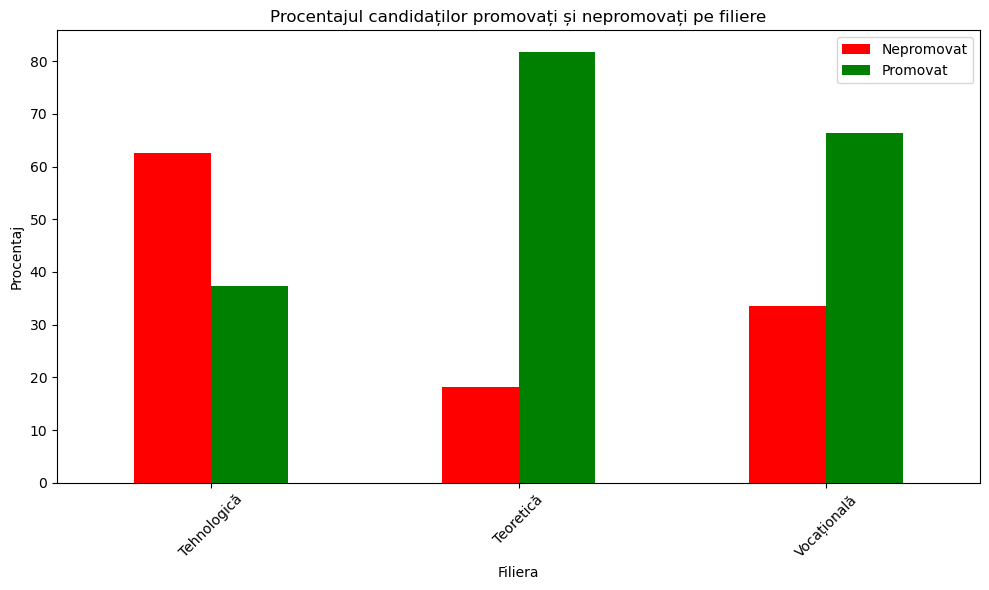

In [22]:
data_bac['Promovat'] = data_bac['STATUS'].apply(lambda x: 1 if str(x).lower() == 'promovat' else 0)

filiera_status = data_bac.groupby('Filiera')['Promovat'].value_counts(normalize=True).unstack() * 100

filiera_status.plot(kind='bar', stacked=False, color=['red', 'green'], figsize=(10, 6))

plt.title('Procentajul candidaților promovați și nepromovați pe filiere')
plt.xlabel('Filiera')
plt.ylabel('Procentaj')
plt.xticks(rotation=45)
plt.legend(['Nepromovat', 'Promovat'], loc='upper right')
plt.tight_layout()

# Afișarea graficului
plt.show()

In [6]:
# Load the Bacalaureate results dataset
bac_results = pd.read_csv("./BAC CSV/bac2019.csv")  # Replace with the actual file path

In [11]:
# Data Preprocessing
bac_results_clean = bac_results.copy()
bac_results_clean = bac_results_clean.dropna(subset=['Medie'])
bac_results_clean['Medie'] = bac_results_clean['Medie'].astype(float)

# Convert all categorical columns to numeric
label_encoder = LabelEncoder()
categorical_cols = bac_results_clean.select_dtypes(include='object').columns
for col in categorical_cols:
    bac_results_clean[col] = label_encoder.fit_transform(bac_results_clean[col].astype(str))

# Handle any negative or invalid scores
for col in bac_results_clean.columns:
    if 'NOTA_FINALA' in col or col == 'Medie':
        bac_results_clean[col] = bac_results_clean[col].apply(lambda x: np.nan if x < 0 else x)

# Fill remaining NaN values with the mean of each column
bac_results_clean.fillna(bac_results_clean.mean(), inplace=True)

# Features and target for classification
X_class = bac_results_clean.drop(columns=['STATUS', 'Medie', 'Cod unic candidat'])
y_class = bac_results_clean['STATUS']

# Scale features
scaler = StandardScaler()
X_class_scaled = scaler.fit_transform(X_class)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_class_scaled, y_class, test_size=0.3, random_state=42)


In [13]:
# 1. Logistic Regression - Predict Pass/Fail
# Purpose: Predicts whether a student will pass or fail based on their features.
# Type: Classification (binary)
# Output: Probability of passing or failing.
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      2202
           1       1.00      1.00      1.00     26799

    accuracy                           1.00     29001
   macro avg       1.00      0.99      0.99     29001
weighted avg       1.00      1.00      1.00     29001

Confusion Matrix:
 [[ 2149    53]
 [    0 26799]]


In [14]:
# 2. Random Forest Classifier
# Purpose: Improves pass/fail prediction using an ensemble of decision trees.
# Type: Classification
# Output: More robust and accurate pass/fail prediction than Logistic Regression.
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("Classification Report for Random Forest:\n", classification_report(y_test, y_pred_rf))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.99      0.89      0.94      2202
           1       0.99      1.00      1.00     26799

    accuracy                           0.99     29001
   macro avg       0.99      0.95      0.97     29001
weighted avg       0.99      0.99      0.99     29001



In [15]:
# 3. Linear Regression - Predict Final Grade
# Purpose: Predicts a student’s exact final grade based on their subject scores and demographics.
# Type: Regression
# Output: Continuous value representing the predicted grade.
X_reg = bac_results_clean.drop(columns=['Medie', 'Cod unic candidat', 'STATUS'])
y_reg = bac_results_clean['Medie']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)
reg = LinearRegression()
reg.fit(X_train_reg, y_train_reg)
y_pred_reg = reg.predict(X_test_reg)
print("Mean Squared Error for Linear Regression:", mean_squared_error(y_test_reg, y_pred_reg))

Mean Squared Error for Linear Regression: 0.0022741973111608093


In [16]:
# 4. Random Forest Regressor
# Purpose: Predicts the final grade using multiple decision trees for more accurate predictions.
# Type: Regression
# Output: More accurate grade prediction than Linear Regression.
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)
y_pred_rf_reg = rf_reg.predict(X_test_reg)
print("Mean Squared Error for Random Forest Regressor:", mean_squared_error(y_test_reg, y_pred_rf_reg))

Mean Squared Error for Random Forest Regressor: 0.0023626127871452744


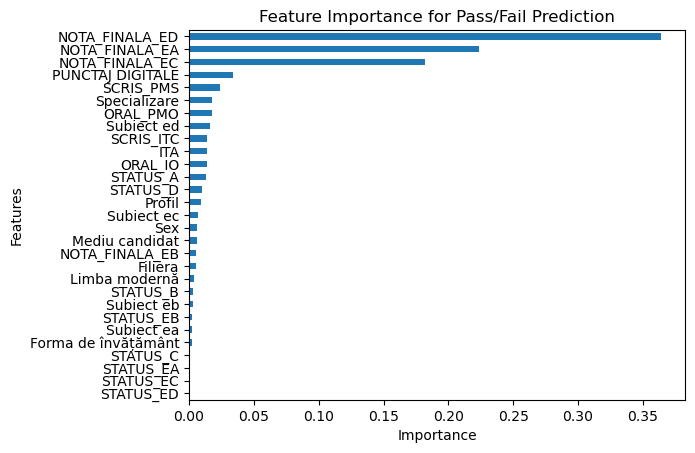

In [17]:
# 5. Feature Importance
# Purpose: Identifies which features (e.g., subjects, specialization) are most important for predicting pass/fail outcomes.
# Type: Interpretation
# Output: Bar plot showing feature impact on predictions.
feature_importances = pd.Series(rf_clf.feature_importances_, index=X_class.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importance for Pass/Fail Prediction')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

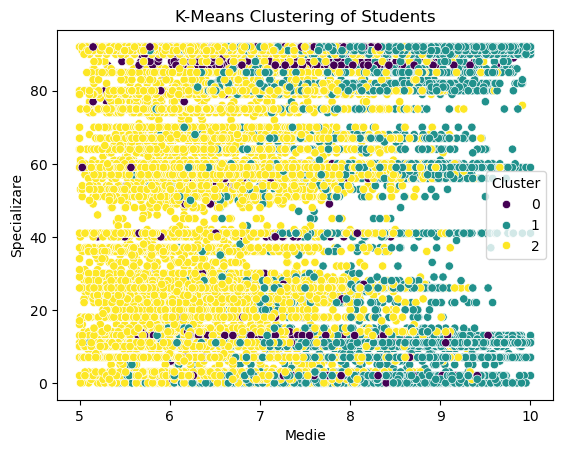

In [18]:
# 6. K-Means Clustering
# Purpose: Groups students into clusters based on similarities in their data (e.g., performance, specialization).
# Type: Unsupervised Learning (Clustering)
# Output: Clusters of students visualized in a scatter plot.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_class)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
bac_results_clean['Cluster'] = kmeans.labels_
sns.scatterplot(x='Medie', y='Specializare', hue='Cluster', data=bac_results_clean, palette='viridis')
plt.title('K-Means Clustering of Students')
plt.show()

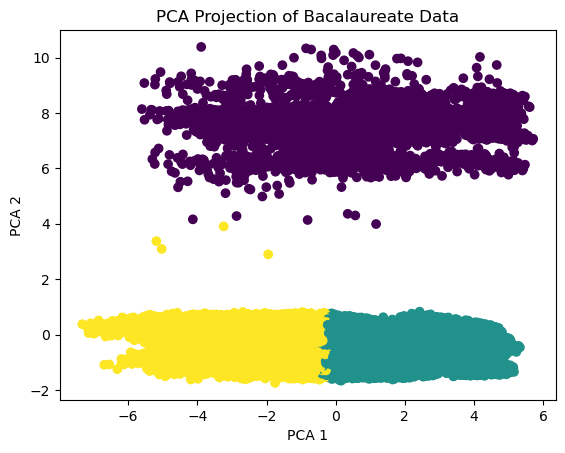

In [19]:
# 7. PCA for Visualization
# Purpose: Reduces data dimensions to 2D for easier visualization of student distribution.
# Type: Dimensionality Reduction
# Output: 2D scatter plot showing student distribution and cluster separation.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA Projection of Bacalaureate Data')
plt.show()


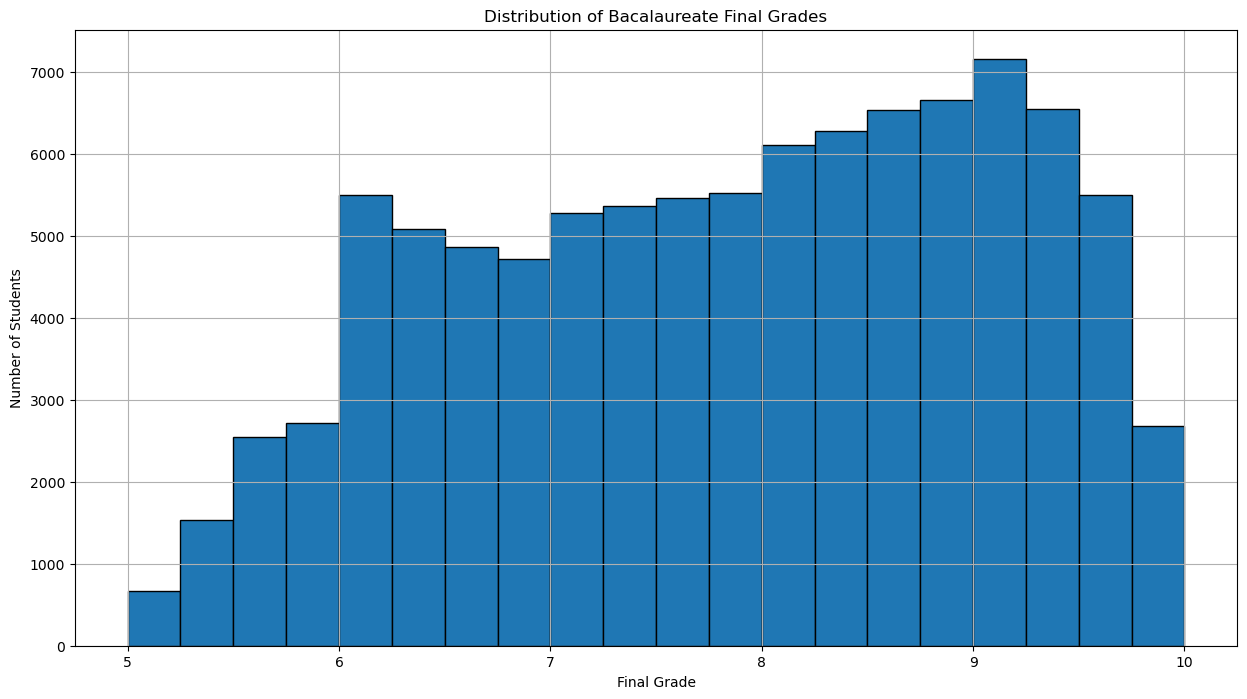

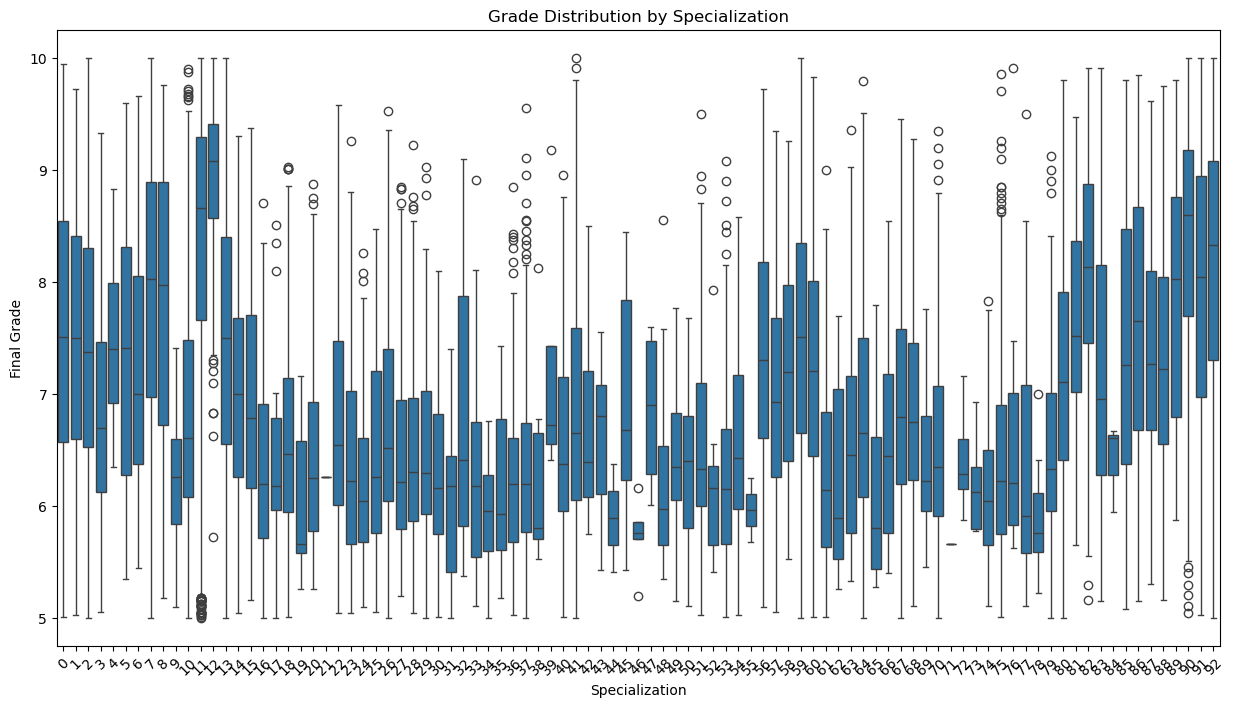

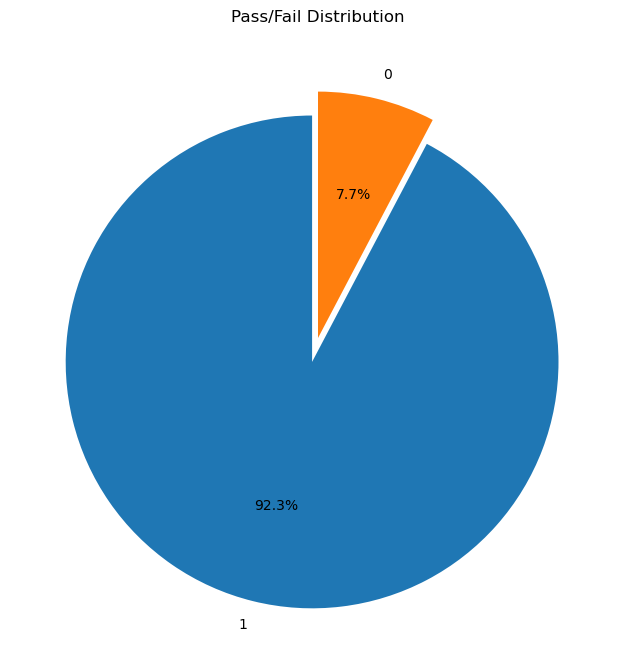

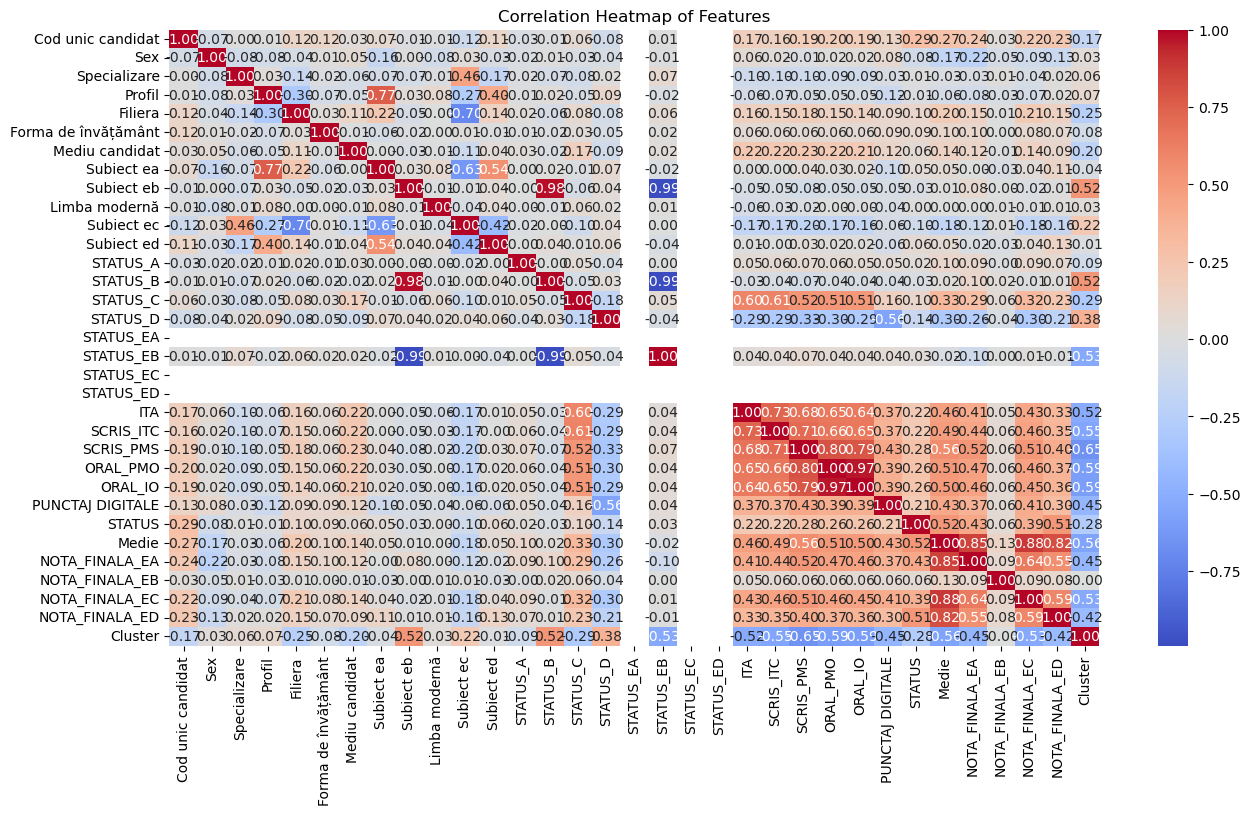

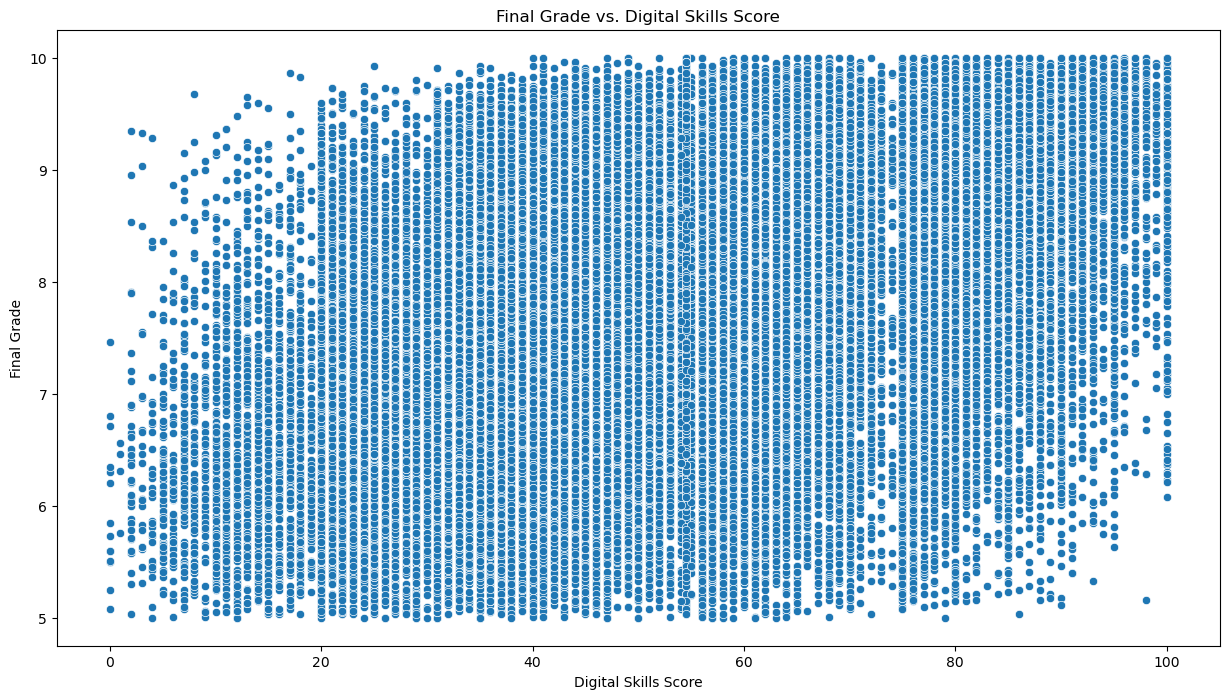

In [23]:
# 1. Histogram of Bacalaureate Final Grades
plt.figure()
bac_results_clean['Medie'].hist(bins=20, edgecolor='black')
plt.xlabel('Final Grade')
plt.ylabel('Number of Students')
plt.title('Distribution of Bacalaureate Final Grades')
plt.show()

# 2. Boxplot of Grades by Specialization
plt.figure()
sns.boxplot(x='Specializare', y='Medie', data=bac_results_clean)
plt.xlabel('Specialization')
plt.ylabel('Final Grade')
plt.title('Grade Distribution by Specialization')
plt.xticks(rotation=45)
plt.show()

# 3. Pass/Fail Rate
plt.figure()
status_counts = bac_results_clean['STATUS'].value_counts()
status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, explode=(0.1, 0))
plt.ylabel('')
plt.title('Pass/Fail Distribution')
plt.show()

# 4. Correlation Heatmap of Final Scores
plt.figure()
sns.heatmap(bac_results_clean.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features')
plt.show()

# 5. Scatter Plot - Final Grade vs. Digital Score
plt.figure()
sns.scatterplot(x='PUNCTAJ DIGITALE', y='Medie', data=bac_results_clean)
plt.xlabel('Digital Skills Score')
plt.ylabel('Final Grade')
plt.title('Final Grade vs. Digital Skills Score')
plt.show()